In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
loan_df = pd.read_csv('loan.csv')
payment_df = pd.read_csv('payment.csv')
user_df = pd.read_csv('user.csv')

In [4]:
# Filter and encode loan status
filtered_loan_df = loan_df[loan_df['status'].isin(['paid', 'overdue'])]
filtered_loan_df['status_encoded'] = filtered_loan_df['status'].map({'paid': 1, 'overdue': 0})

# Merge datasets
merged_df = pd.merge(filtered_loan_df, user_df, left_on='client_id', right_on='id', suffixes=('_loan', '_user'))
final_df = pd.merge(merged_df, payment_df, left_on='id_loan', right_on='loan_id', how='left')

# Calculate age from birth_date
final_df['birth_date'] = pd.to_datetime(final_df['birth_date'])
current_year = pd.Timestamp.now().year
final_df['age'] = current_year - final_df['birth_date'].dt.year
final_df.drop('birth_date', axis=1, inplace=True)

# Handle missing values
final_df['amount_y'].fillna(0, inplace=True)
final_df['principle'].fillna(0, inplace=True)
final_df['interest'].fillna(0, inplace=True)
final_df['status_y'].fillna('no_payment', inplace=True)

/tmp/ipykernel_154905/377295015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loan_df['status_encoded'] = filtered_loan_df['status'].map({'paid': 1, 'overdue': 0})


In [5]:
# One-hot encode categorical features
final_df_encoded = pd.get_dummies(final_df, columns=['status_y'])

# Define features and target
features = ['amount_x', 'duration', 'age', 'principle', 'interest'] + [col for col in final_df_encoded if 'status_y_' in col]
X = final_df_encoded[features]
y = final_df_encoded['status_encoded']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Train a logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [7]:
# Predict and evaluate on test set
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [8]:
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9995849884389637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3529
           1       1.00      1.00      1.00     13338

    accuracy                           1.00     16867
   macro avg       1.00      1.00      1.00     16867
weighted avg       1.00      1.00      1.00     16867


In [9]:
# Cross-validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_accuracies = cross_val_score(log_reg, X, y, cv=strat_kfold, scoring='accuracy')


In [10]:
print(f'Cross-validation accuracies: {cross_val_accuracies}')

Cross-validation accuracies: [0.99964428 0.99964428 0.99922926 0.99940713 0.99940709]


In [11]:
# ROC curve and AUC
y_scores = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_score = roc_auc_score(y_test, y_scores)

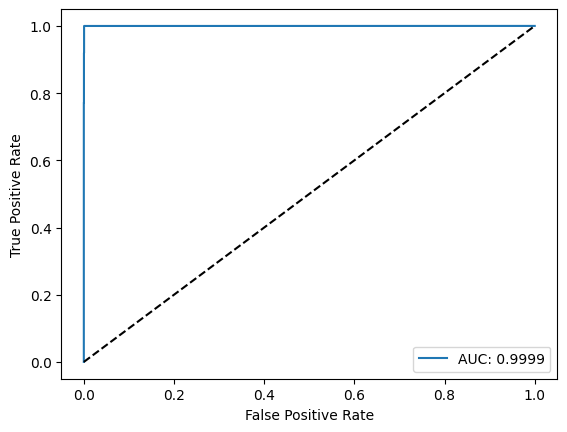

In [12]:
# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC: {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [13]:
# Predict loan approval probabilities for the entire dataset
all_predictions = log_reg.predict(X)

# Calculate percentage of loans predicted as approved
approved_percentage = (all_predictions.sum() / len(all_predictions)) * 100
print(f"Percentage of loans predicted as approved: {approved_percentage:.2f}%")


Percentage of loans predicted as approved: 79.37%


In [14]:
# Calculate average loan amount for approved and rejected loans
approved_df = final_df_encoded[all_predictions == 1]
rejected_df = final_df_encoded[all_predictions == 0]
print(f"Average loan amount for approved loans: {approved_df['amount_x'].mean():.2f}")

Average loan amount for approved loans: 1052.63


In [15]:
print(f"Average loan amount for rejected loans: {rejected_df['amount_x'].mean():.2f}")

Average loan amount for rejected loans: 1155.61


In [16]:
# Save the model as model_v2
from joblib import dump
dump(log_reg, 'model_v2.joblib')

['model_v2.joblib']

Index(['amount_x', 'duration', 'age', 'principle', 'interest', 'status_y_late',
       'status_y_no_payment', 'status_y_on_time'],
      dtype='object')
